# Imports

In [31]:
import time

import numpy             as np
import scipy             as sc
import scipy.stats       as st
import tables            as tb
import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm

import invisible_cities.core    .system_of_units_c as system_of_units
import invisible_cities.core    .fit_functions     as fitf
import invisible_cities.database.load_db           as db

from   invisible_cities.icaro.hst_functions import hist
from   invisible_cities.icaro.hst_functions import labels
from   invisible_cities.icaro.hst_functions import shift_to_bin_centers

units = system_of_units.SystemOfUnits()

# Plotting configuration

In [32]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

# NEXT detector properties

In [70]:
class NEXTparams:
    def __init__(self, **kwargs): 
        self.DataPMT                = db.DataPMT(0)
        self.DataSiPM               = db.DataSiPM(0) 
        
        self.attachment             = 1e12 * units.mus
        self.transverse_diffusion   = 1.00 * units.mm / units.cm**0.5
        self.longitudinal_diffusion = 0.30 * units.mm / units.cm**0.5

        self.w_s                    = 60.0 * units.eV
        self.w_i                    = 22.4 * units.eV
        self.fano_factor            = 0.15
        self.conde_policarpo_factor = 0.10

        self.max_drift_length       = 532  * units.mm
        self.drift_velocity         = 1.00 * units.mm / units.mus

        self.n_pmt                  = 12
        self.n_sipm                 = 28*64

        self.n_bin_pmt              = 20
        self.n_bin_sipm             = 2

        self.pmt_bin_size           = 100 * units.ns
        self.sipm_bin_size          = 1   * units.mus

        self.wf_size                = 1.2 * units.ms
        self.pmt_wf_size            = int(self.wf_size // self.pmt_bin_size)
        self.sipm_wf_size           = int(self.wf_size // self.sipm_bin_size)

        self. pmt_wf                = np.zeros((self.n_pmt , self. pmt_wf_size), dtype=int)
        self.sipm_wf                = np.zeros((self.n_sipm, self.sipm_wf_size), dtype=int)

        self.el_gain                = 1e3
        self.EP_z                   = 632 * units.mm
        self.TP_z                   = -5  * units.mm
        
        self. pmt_bins              = np.arange(0, self.n_bin_pmt ) * self. pmt_bin_size
        self.sipm_bins              = np.arange(0, self.n_bin_sipm) * self.sipm_bin_size

        self.S1_sample_times,\
        self.S1_sample_probs        = NEXTparams.compute_S1_sample_times(0, 500, 500)

        self.S1_sample_times_pmt,\
        self.S1_sample_probs_pmt    = NEXTparams.compute_S2_sample_times(self.n_bin_pmt , self. pmt_bin_size)

        self.S1_sample_times_sipm,\
        self.S1_sample_probs_sipm   = NEXTparams.compute_S2_sample_times(self.n_bin_sipm, self.sipm_bin_size)

        self.trigger_time           = 100 * units.mus
        self.update(**kwargs)

    def update(self, **kwargs):
        for attr, value in kwargs.items():
            setattr(self, attr, value)

    def get_pmt_wf(self):
        return self.pmt_wf.copy()

    def get_sipm_wf(self):
        return self.sipm_wf.copy()

    def get_s1_sample_time(self, n=1):
        return np.random.choice(self.S1_sample_times, size=n, p=self.S1_sample_probs)

    def get_s2_sample_time_pmt(self, n=1):
        return np.random.choice(self.S2_sample_times_pmt , size=n, p=self.S2_sample_probs_pmt )

    def get_s2_sample_time_sipm(self, n=1):
        return np.random.choice(self.S2_sample_times_sipm, size=n, p=self.S2_sample_probs_sipm)

    def S1_sample_time(t):
        return (0.9 * np.exp(-t / 1  / units.ns)  +
                0.1 * np.exp(-t / 45 / units.ns)) / 5.4


    def compute_S1_sample_times(tmin=0, tmax=500, nbins=5000):
        t = np.linspace(tmin, tmax, nbins+1)
        p = np.array([sc.integrate.quad(NEXTparams.S1_sample_time,
                                        t[i], t[i+1])[0] for i in range(nbins)])
        return shift_to_bin_centers(t), p/np.sum(p)

    def compute_S2_sample_times(n_bin=20, bin_size=100*units.ns):
        t = np.arange(n_bin) * bin_size
        p = np.full_like(t, 1/n_bin)
        return t, p/np.sum(p)

NEXT = NEXTparams()

# Light-emission-related functions

In [71]:
def psf(dx, dy, dz):
    return np.abs(dz)/(2*np.pi)/(dx**2 + dy**2 + dz**2)**1.5


def get_s1_pmt_probabilities(x, y, z):
    pmt_x = NEXT.DataPMT.X.values
    pmt_y = NEXT.DataPMT.Y.values
    dx = x[:, np.newaxis] - pmt_x
    dy = y[:, np.newaxis] - pmt_y
    dz = (NEXT.EP_z - z)[:, np.newaxis]
    return psf(dx, dy, dz) * 1e3 # x1000 needed for realistic response


def get_s2_pmt_probabilities(x, y):
    return get_s1_pmt_probabilities(x, y, np.zeros_like(x))


def get_s2_sipm_probabilities(x, y):
    sipm_x = NEXT.DataSiPM.X.values
    sipm_y = NEXT.DataSiPM.Y.values
    dx = x[np.newaxis].T - sipm_x
    dy = y[np.newaxis].T - sipm_y
    return psf(dx, dy, NEXT.TP_z)

# Ionization-electrons-related functions

In [72]:
def poisson_fluctuate_fano(mean):
    n_ie        = np.zeros_like(mean, dtype=int)
    lowE        = mean <= 10
    n_ie[ lowE] = np.random.poisson(mean[lowE])
    n_ie[~lowE] = np.round(np.random.normal(mean[~lowE], np.sqrt(mean[~lowE]*NEXT.fano_factor)))
    return n_ie


def simulate_attachment(ie, z):
    attach = lambda x, y: np.count_nonzero(-NEXT.attachment * np.log(np.random.rand(x)) > y)
    return np.array(list(map(attach, ie, z /NEXT.drift_velocity)))


def simulate_diffusion(x, y, z):
    sqrtz = z**0.5

    x = np.random.normal(x, NEXT.  transverse_diffusion * sqrtz)
    y = np.random.normal(y, NEXT.  transverse_diffusion * sqrtz)
    z = np.random.normal(z, NEXT.longitudinal_diffusion * sqrtz)
    return x, y, np.clip(z, 0, NEXT.max_drift_length)


def create_ionization_electrons(x, y, z, E):
    mean_ie = E / NEXT.w_i
    ie      = poisson_fluctuate_fano(mean_ie)
    ie      = simulate_attachment(ie, z)

    x = np.repeat(x, ie)
    y = np.repeat(y, ie)
    z = np.repeat(z, ie)

    x, y, z = simulate_diffusion(x, y, z)
    return x, y, z / NEXT.drift_velocity

# Core functions

In [57]:
def simulate_S1(x, y, z, E):
    n_phot = np.random.poisson(E/NEXT.w_s)
    probs  = get_s1_pmt_probabilities(x, y, z)
    nphot  = np.random.poisson(probs.T.dot(n_phot))
    return list(map(NEXT.get_s1_sample_time, nphot))


def simulate_S2(x, y, z, E):
    x, y, t    = create_ionization_electrons(x, y, z, E)
    nphot      = np.random.normal (NEXT.el_gain,
                                   (NEXT.el_gain * 
                                    NEXT.conde_policarpo_factor)**0.5,
                                   size = (t.size, 1))

    pmt_probs  = get_s2_pmt_probabilities (x, y)
    sipm_probs = get_s2_sipm_probabilities(x, y)

    #Repartir Nphotons detectados entre os m time bins
    pmt_nphot  = np.random.poisson( pmt_probs * nphot)
    sipm_nphot = np.random.poisson(sipm_probs * nphot)

    return [np.repeat(t, n) for n in  pmt_nphot.T],\
           [np.repeat(t, n) for n in sipm_nphot.T]

"""
def find_time_bin(times, bin_size):
    return (times // bin_size).astype(int)


def create_waveforms(x, y, z, E):
    s1_pmt  = simulate_S1(x, y, z, E)
    s2_pmt, \
    s2_sipm = simulate_S2(x, y, z, E)
    s12_pmt = list(map(np.concatenate, zip(s1_pmt, s2_pmt)))

    pmt_wf  = NEXT.get_pmt_wf()
    sipm_wf = NEXT.get_sipm_wf()

    for pmt in range(NEXT.n_pmt):
        time_bins   = find_time_bin(NEXT.trigger_time + s12_pmt[pmt], NEXT.pmt_bin_size)
        unique_bins = list(set(time_bins))
        nphot       = np.array([np.count_nonzero(time_bins == time_bin)\
                                for time_bin in unique_bins])

        pmt_wf[pmt, unique_bins] = nphot

    for sipm in range(NEXT.n_sipm):
        time_bins   = find_time_bin(NEXT.trigger_time + s2_sipm[sipm], NEXT.sipm_bin_size)
        unique_bins = list(set(time_bins))
        nphot       = np.array([np.count_nonzero(time_bins == time_bin)\
                                for time_bin in unique_bins])

        sipm_wf[sipm, unique_bins] = nphot

    return pmt_wf, sipm_wf
"""

def fill_waveform(bin_size):
    def find_time_bin_(times):
        return (times // bin_size).astype(int)

    def fill_waveform_(times, wf):
        time_bins   = find_time_bin_(NEXT.trigger_time + times)
        unique_bins = list(set(time_bins))
        nphot       = np.array([np.count_nonzero(time_bins == time_bin)\
                                for time_bin in unique_bins])

        wf[unique_bins] = nphot
    return fill_waveform_


def simulate_light_emission(x, y, z, E):
    s1_pmt  = simulate_S1(x, y, z, E)
    s2_pmt, \
    s2_sipm = simulate_S2(x, y, z, E)
    s12_pmt = list(map(np.concatenate, zip(s1_pmt, s2_pmt)))
    return s12_pmt, s2_sipm


def create_waveforms(pmt_times, sipm_times):
    pmt_wf  = NEXT.get_pmt_wf()
    sipm_wf = NEXT.get_sipm_wf()

    list(map(fill_waveform(NEXT. pmt_bin_size),  pmt_times,  pmt_wf))
    list(map(fill_waveform(NEXT.sipm_bin_size), sipm_times, sipm_wf))

    return pmt_wf, sipm_wf


def simulate_event(x, y, z, E):
    return create_waveforms(*simulate_light_emission(x, y, z, E))

# Testing

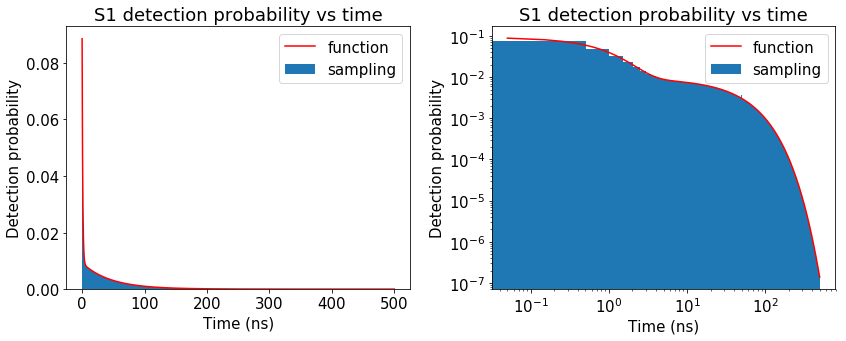

In [58]:
def test_compute_S1_sample_times(n=int(1e4)):
    times, probs = NEXTparams.compute_S1_sample_times(0, 500, 5000)
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.hist(times, np.linspace(0, 500, 1000), weights=probs, label="sampling")
    plt.plot(times, NEXTparams.S1_sample_time(times) * 0.5, "-r", label="function")
    plt.legend()
    labels("Time (ns)", "Detection probability", "S1 detection probability vs time")
    
    plt.subplot(1,2,2)
    plt.hist(times, np.linspace(0, 500, 1000), weights=probs, label="sampling")
    plt.plot(times, NEXTparams.S1_sample_time(times) * 0.5, "-r", label="function")
    plt.legend()
    plt.xscale("log")
    plt.yscale("log")
    labels("Time (ns)", "Detection probability", "S1 detection probability vs time")

    plt.tight_layout()

test_compute_S1_sample_times()

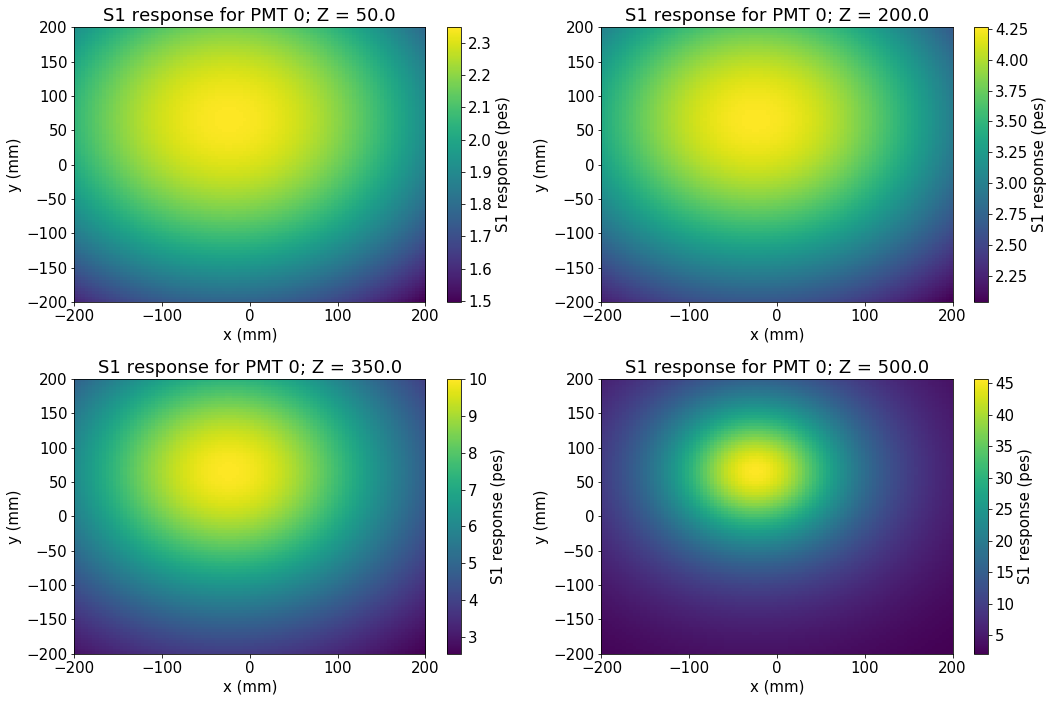

In [59]:
def test_s1_pmt_probabilities(pmt=0):
    x0, y0 = np.linspace(-200, 200, 101), np.linspace(-200, 200, 101)
    x , y  = np.repeat(shift_to_bin_centers(x0), 100), np.tile(shift_to_bin_centers(y0), 100)
    
    plt.figure(figsize=(15,10))
    for i, z in enumerate(np.linspace(50, 500, 4)):
        p  = get_s1_pmt_probabilities(x, y, np.full_like(x, z))[:, pmt]
        plt.subplot(2, 2, i+1)
        plt.hist2d(x, y, (x0, y0), weights=p.flatten()*5e3)
        labels("x (mm)", "y (mm)", "S1 response for PMT {}; Z = {}".format(pmt, z))
        plt.colorbar().set_label("S1 response (pes)")
    plt.tight_layout()

test_s1_pmt_probabilities()

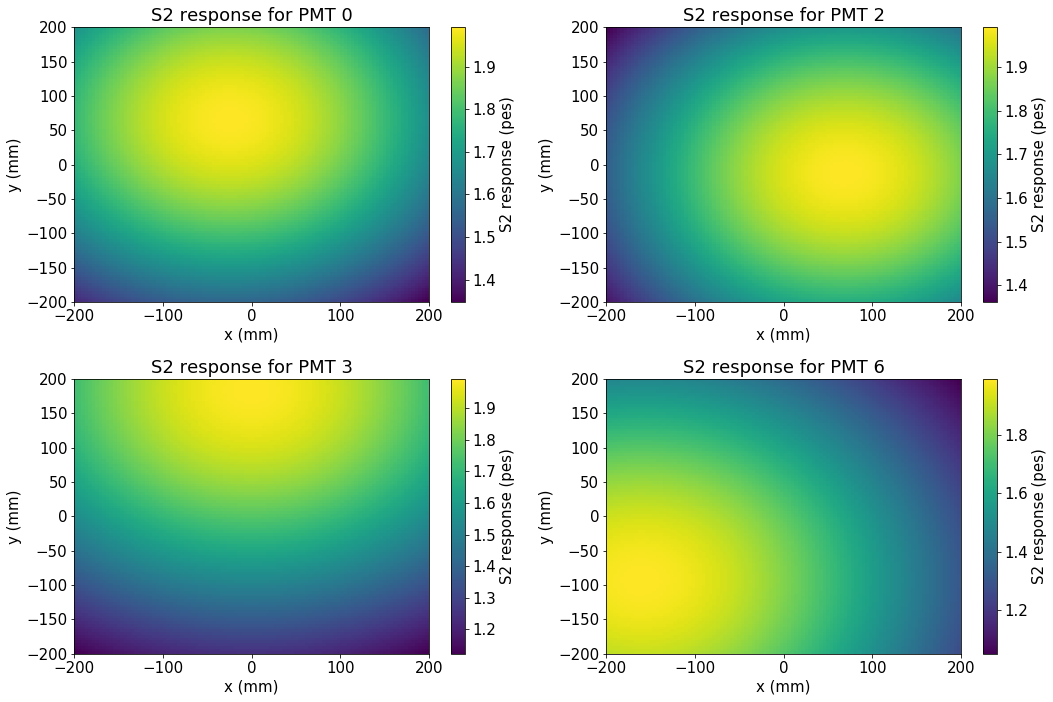

In [60]:
def test_s2_pmt_probabilities(pmts=[0,2,3,6]):
    x0, y0 = np.linspace(-200, 200, 101), np.linspace(-200, 200, 101)
    x , y  = np.repeat(shift_to_bin_centers(x0), 100), np.tile(shift_to_bin_centers(y0), 100)
    ps     = get_s2_pmt_probabilities(x, y)
    
    plt.figure(figsize=(15,10))
    for i, pmt in enumerate(pmts):
        plt.subplot(2, 2, i+1)
        plt.hist2d(x, y, (x0, y0), weights=ps[:, pmt]*5e3)
        labels("x (mm)", "y (mm)", "S2 response for PMT {}".format(pmt))
        plt.colorbar().set_label("S2 response (pes)")
    plt.tight_layout()

test_s2_pmt_probabilities()

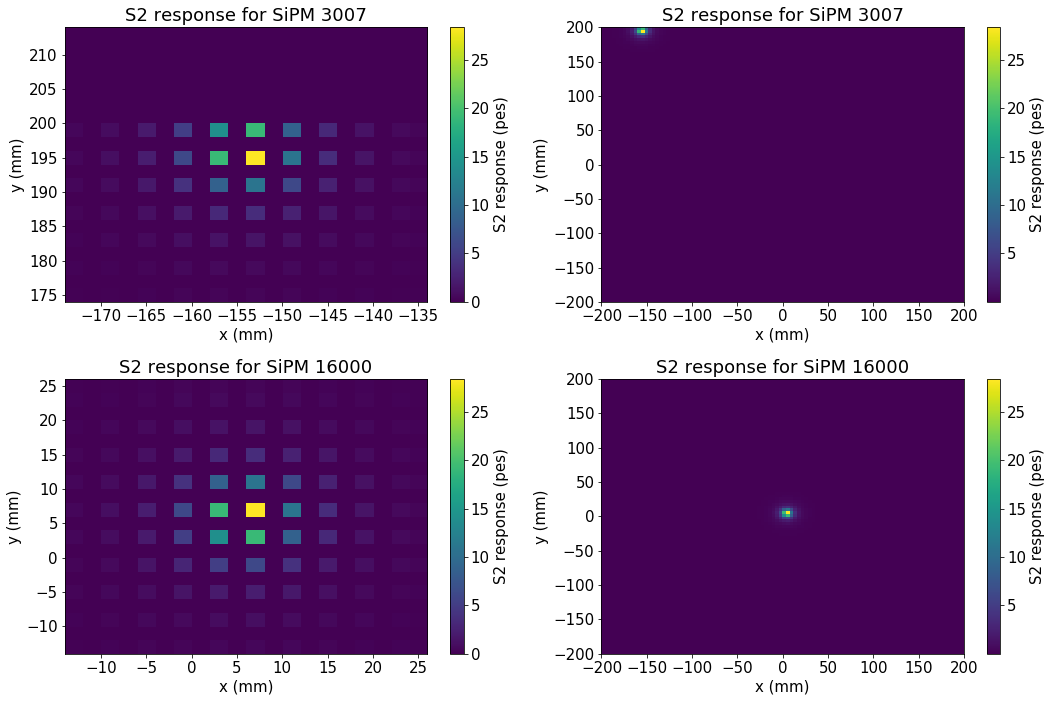

In [61]:
def test_s2_sipm_probabilities(sipms=[3*64+7, 16*64]):
    x0, y0 = np.linspace(-200, 200, 101), np.linspace(-200, 200, 101)
    x , y  = np.repeat(shift_to_bin_centers(x0), 100), np.tile(shift_to_bin_centers(y0), 100)
    ps     = get_s2_sipm_probabilities(x, y)

    plt.figure(figsize=(15,10))
    for i, sipm in enumerate(sipms):
        plt.subplot(2, 2, 2*i+1)
        p = ps[:, sipm]

        pmax       = np.argmax(p)
        xmin, xmax = x[pmax]-20, x[pmax]+20
        ymin, ymax = y[pmax]-20, y[pmax]+20

        plt.hist2d(x, y, 20, ((xmin, xmax),
                              (ymin, ymax)), weights=p*5e3)
        labels("x (mm)", "y (mm)", "S2 response for SiPM {}".format(sipm//64*1000 + sipm%64))
        plt.colorbar().set_label("S2 response (pes)")

        plt.subplot(2, 2, 2*i+2)
        plt.hist2d(x, y, (x0, y0), weights=p*5e3)
        labels("x (mm)", "y (mm)", "S2 response for SiPM {}".format(sipm//64*1000 + sipm%64))
        plt.colorbar().set_label("S2 response (pes)")
    plt.tight_layout()

test_s2_sipm_probabilities()

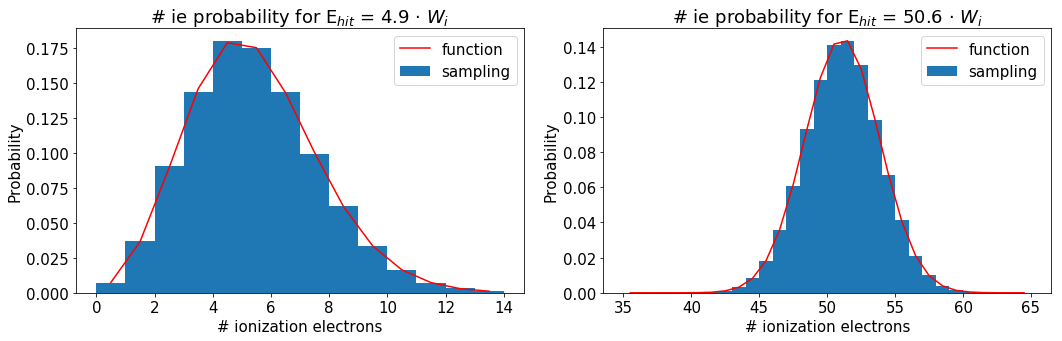

In [62]:
def test_poisson_fluctuate_fano(nsamples=100000):
    plt.figure(figsize=(15,5))
    means = 4.9, 50.6
    bins  = np.arange(15), np.linspace(35, 65, 31)
    funs  = lambda x: st.poisson.pmf(x, means[0]),\
            lambda x: st.norm   .pdf(x, means[1], (means[1]*NEXT.fano_factor)**0.5)
    
    for i, (mean, binning, fun) in enumerate(zip(means, bins, funs)):
        plt.subplot(1, 2, i+1)
        n_ie = poisson_fluctuate_fano(np.full(nsamples, mean))
        x    = shift_to_bin_centers(binning) 
        plt.hist(n_ie, binning, normed=True, label="sampling")
        plt.plot(x, fun(x - np.diff(binning)[0] * 0.5), "r-", label="function")
        plt.legend()
        labels("# ionization electrons", "Probability", "# ie probability for E$_{{hit}}$ = {} $\cdot$ $W_i$".format(mean))
    plt.tight_layout()
test_poisson_fluctuate_fano()

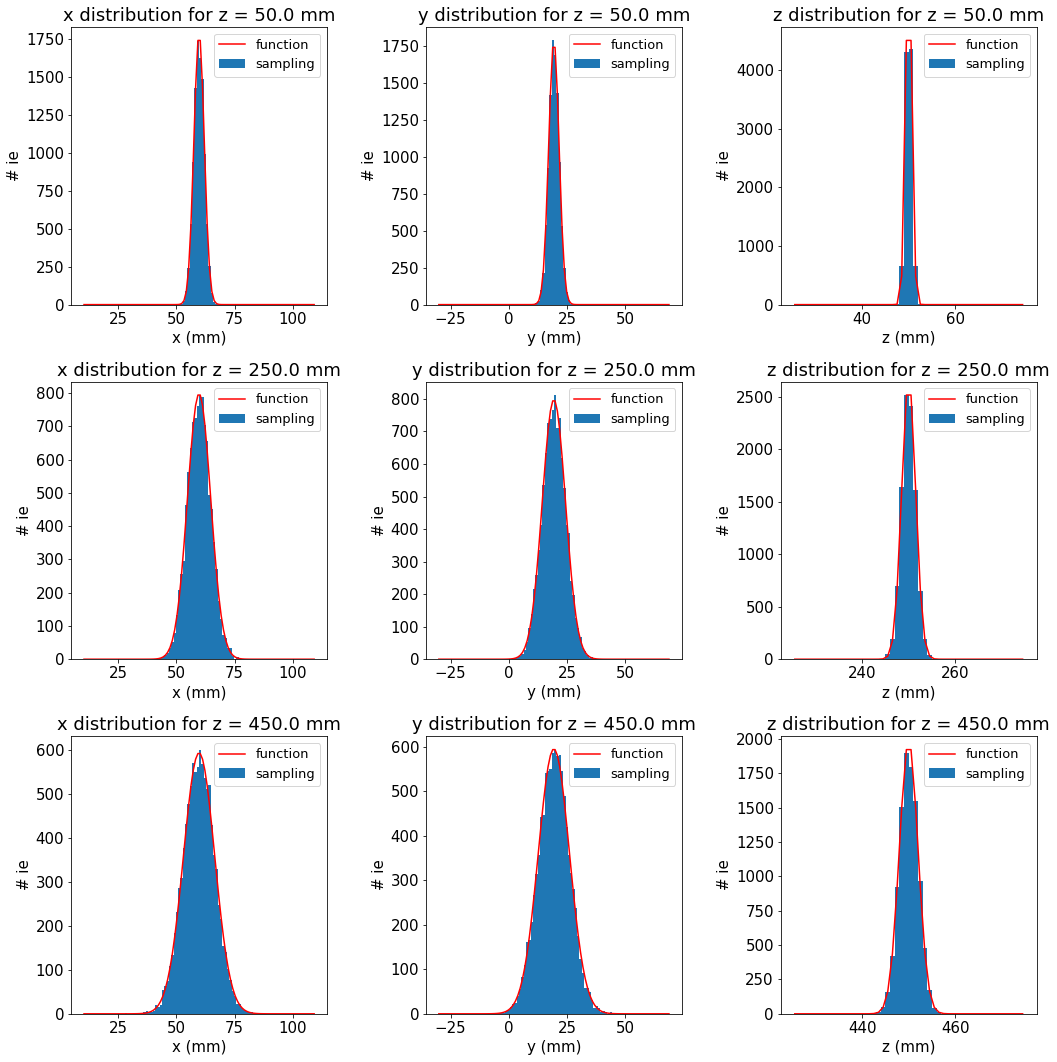

In [63]:
def test_simulate_diffusion(n_ie=10000):
    r0   = np.random.rand()**0.5 * 100
    phi0 = np.random.rand() * 2 * np.pi
    x0   = r0 * np.cos(phi0)
    y0   = r0 * np.sin(phi0)
    zs   = np.linspace(50, 450, 3)

    xbins = np.linspace(x0 - 50, x0 + 50, 101)
    ybins = np.linspace(y0 - 50, y0 + 50, 101)    

    plt.figure(figsize=(15,15))
    for i, z0 in enumerate(zs):
        x, y, z = simulate_diffusion(np.full(n_ie, x0),
                                     np.full(n_ie, y0),
                                     np.full(n_ie, z0))

        plt.subplot(3, 3, 3*i+1)
        yh, xh, _ = \
        hist(x, xbins, new_figure=False, label="sampling")
        plt.plot(xh, fitf.gauss(xh, n_ie, x0, z0**0.5*NEXT.transverse_diffusion), "r-", label="function")
        plt.legend(fontsize=13)
        labels("x (mm)", "# ie", "x distribution for z = {} mm".format(z0))

        plt.subplot(3, 3, 3*i+2)
        yh, xh, _ = \
        hist(y, ybins, new_figure=False, label="sampling")
        plt.plot(xh, fitf.gauss(xh, n_ie, y0, z0**0.5*NEXT.transverse_diffusion), "r-", label="function")
        plt.legend(fontsize=13)
        labels("y (mm)", "# ie", "y distribution for z = {} mm".format(z0))

        plt.subplot(3, 3, 3*i+3)
        yh, xh, _ = \
        hist(z, np.linspace(z0 - 25, z0 + 25, 51), new_figure=False, label="sampling")
        plt.plot(xh, fitf.gauss(xh, n_ie, z0, z0**0.5*NEXT.longitudinal_diffusion), "r-", label="function")
        plt.legend(fontsize=13)
        labels("z (mm)", "# ie", "z distribution for z = {} mm".format(z0))
    plt.tight_layout()

test_simulate_diffusion()

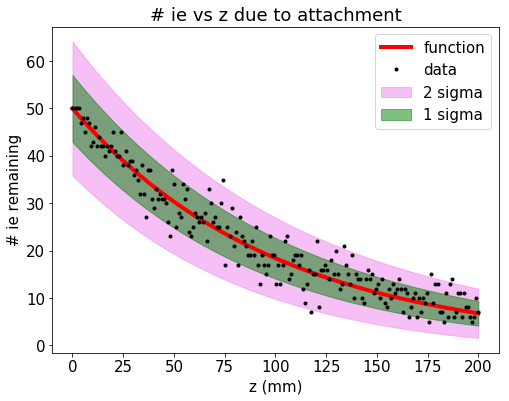

In [64]:
def test_simulate_attachment():
    # temporarily change NEXT properties
    attachment_0    = NEXT.attachment
    NEXT.attachment = 100 * units.mus

    q = np.full    (200,  50, dtype=int)
    z = np.linspace(  0, 200, 200) * units.mm
    
    mean = q * np.exp(-z/NEXT.drift_velocity/NEXT.attachment)
    plt.plot        (z, mean, "r", lw=4, label="function")
    plt.fill_between(z, mean - 2*mean**0.5, mean + 2*mean**0.5, alpha=0.5, color="violet", label="2 sigma")
    plt.fill_between(z, mean - 1*mean**0.5, mean + 1*mean**0.5, alpha=0.5, color="green" , label="1 sigma")
    plt.plot        (z, simulate_attachment(q, z), ".k", label="data")
    plt.legend()
    labels("z (mm)", "# ie remaining", "# ie vs z due to attachment")
    NEXT.attachment = attachment_0

test_simulate_attachment()

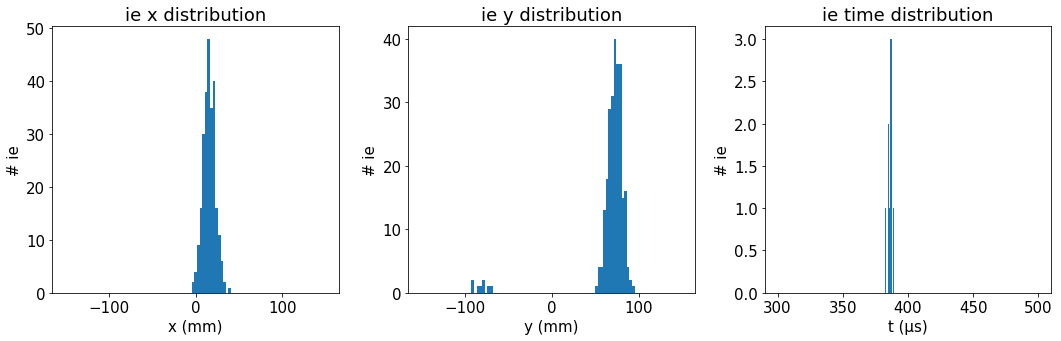

In [65]:
def test_create_ionization_electrons():
    x0, y0  = np.random.rand(2,2) * 200 - 100
    z0      = np.random.rand(2) * 200 + 350
    E0      = np.array([8, 250]) * NEXT.w_i
    x, y, t = create_ionization_electrons(x0 * units.mm,
                                          y0 * units.mm,
                                          z0 * units.mm,
                                          E0           )
    xybins  = np.linspace(-150, 150, 100)
    tbins   = np.linspace( 300, 500, 200)

    plt.figure(figsize=(15, 5))
    plt.subplot(1,3,1)
    plt.hist(x, xybins)
    labels("x (mm)", "# ie", "ie x distribution")

    plt.subplot(1,3,2)
    plt.hist(y, xybins)
    labels("y (mm)", "# ie", "ie y distribution")

    plt.subplot(1,3,3)
    plt.hist(t/units.mus, tbins)
    labels("t (µs)", "# ie", "ie time distribution")
    plt.tight_layout()

test_create_ionization_electrons()

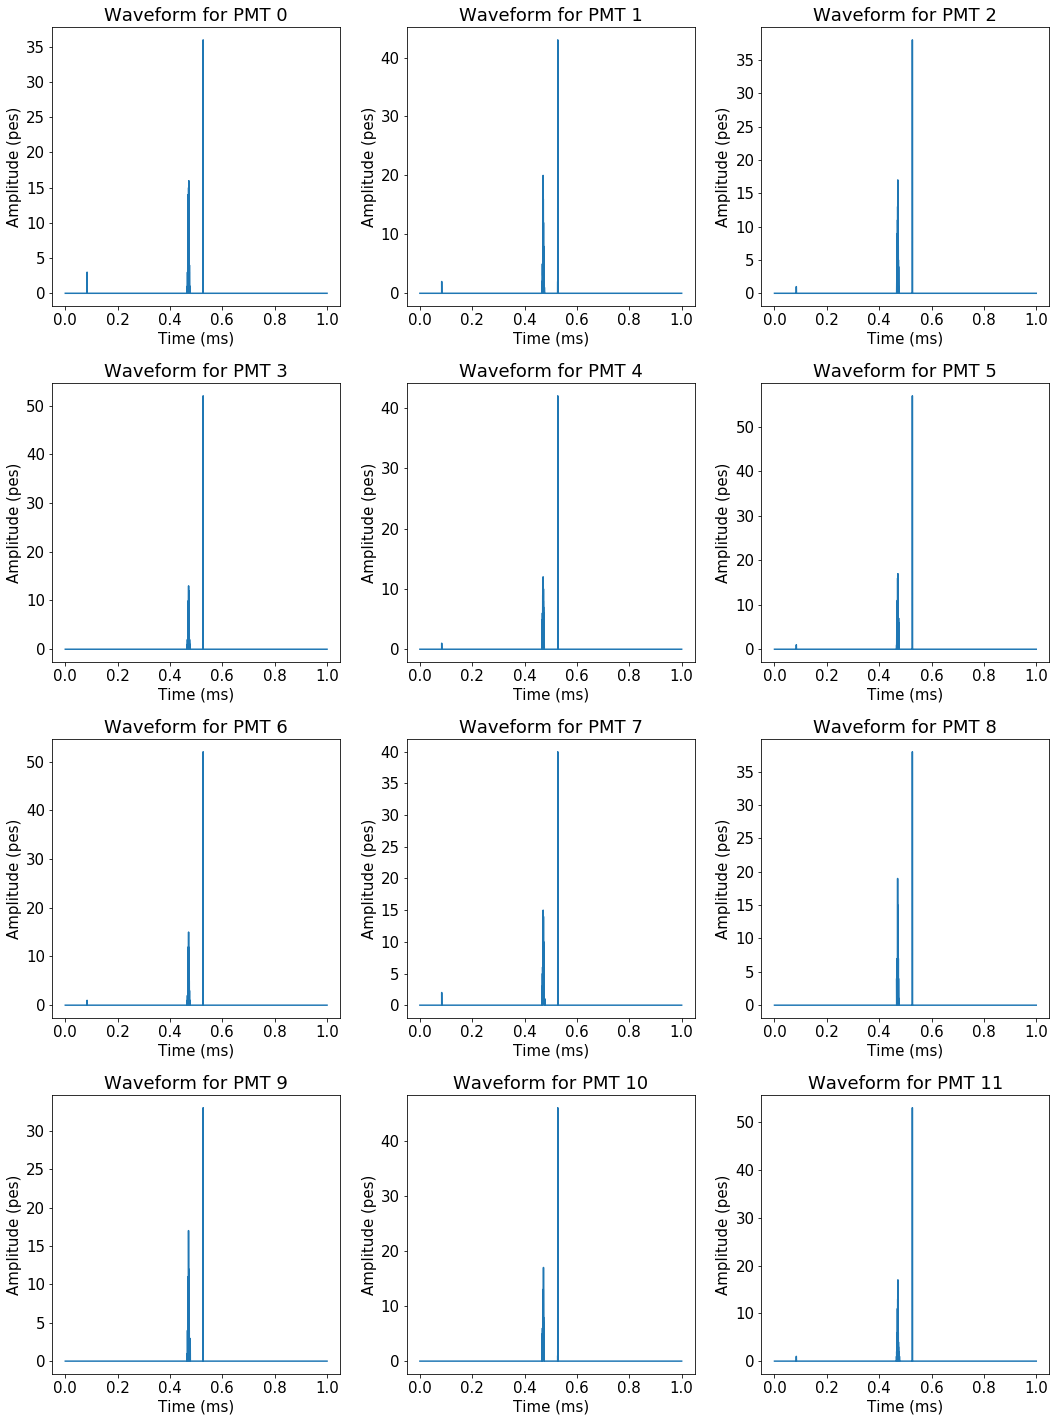

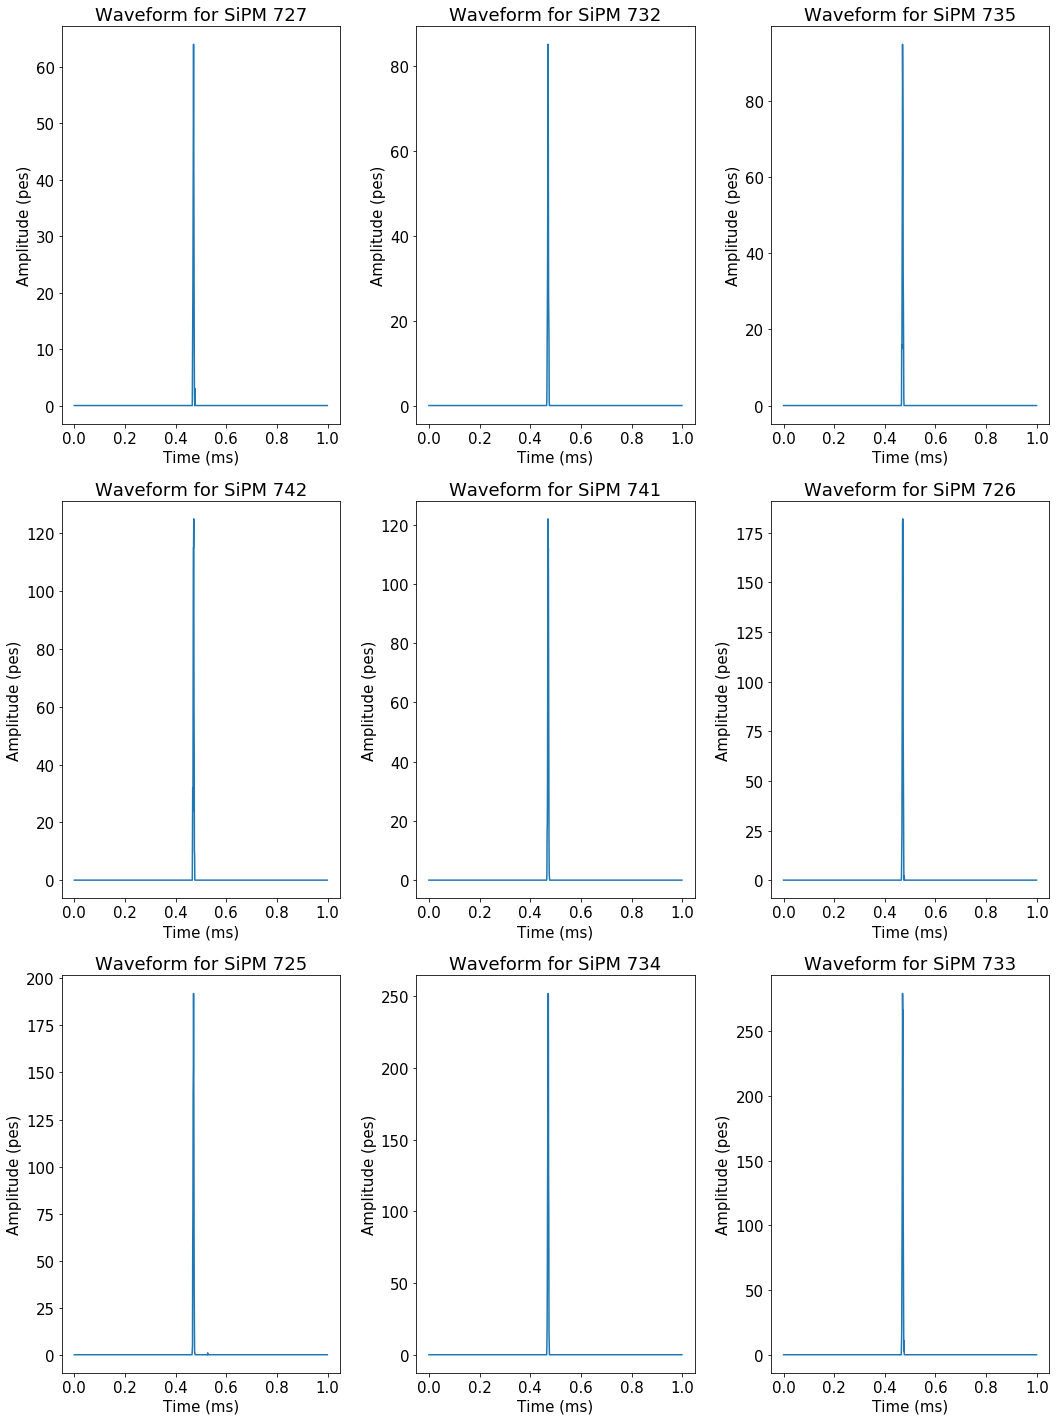

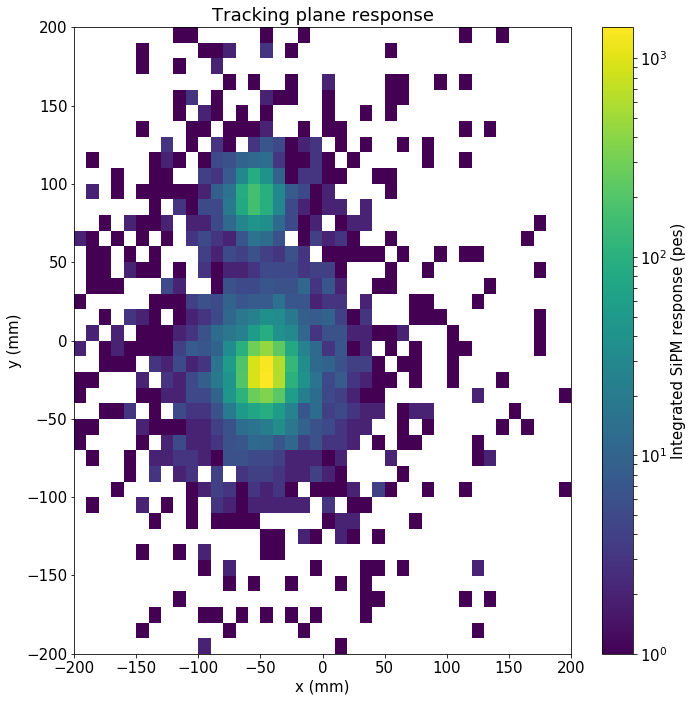

In [66]:
def test_simulate_event():
    x0, y0  = np.random.rand(2,2) * 200 - 100
    z0      = np.random.rand(2) * 200 + 350
    E0      = np.array([3, 25])
    pmt_wf, \
    sipm_wf = simulate_event(x0 * units.mm ,
                             y0 * units.mm ,
                             z0 * units.mm ,
                             E0 * units.keV)
    plt.figure(figsize=(15,20))
    for pmt in range(NEXT.n_pmt):
        plt.subplot(4, 3, pmt + 1)
        plt.plot(np.arange(NEXT.pmt_wf_size)*NEXT.pmt_bin_size/NEXT.wf_size, pmt_wf[pmt])
        labels("Time (ms)", "Amplitude (pes)", "Waveform for PMT {}".format(pmt))
    plt.tight_layout()

    plt.figure(figsize=(15,20))
    best_sipms = list(zip(*sorted(zip(np.sum(sipm_wf, axis=1),np.arange(NEXT.n_sipm)))))[1][-9:]
    for i, sipm in enumerate(best_sipms):
        plt.subplot(3, 3, i + 1)
        plt.plot(np.arange(NEXT.sipm_wf_size)*NEXT.sipm_bin_size/NEXT.wf_size, sipm_wf[sipm])
        labels("Time (ms)", "Amplitude (pes)", "Waveform for SiPM {}".format(sipm))
    plt.tight_layout()

    plt.figure(figsize=(10,10))
    xybins = np.linspace(-200, 200, 41), np.linspace(-200, 200, 41)
    
    plt.hist2d(NEXT.DataSiPM.X.values,
               NEXT.DataSiPM.Y.values,
               xybins, weights=np.sum(sipm_wf, axis=1), norm=LogNorm())
    plt.colorbar().set_label("Integrated SiPM response (pes)")
    labels("x (mm)", "y (mm)", "Tracking plane response")
    plt.tight_layout()

test_simulate_event()

# Timing

In [67]:
def time_simulate_event(x, y, z, E, n=1000):
    t0 = time.time()
    for i in range(n):
        simulate_event(x, y, z, E)
    return (time.time() - t0)/n

### 1-hit Kr events

In [69]:
x = np.zeros(1)       * units.mm
y = np.zeros(1)       * units.mm
z = np.full (1, 400)  * units.mm
E = np.full (1, 41.5) * units.keV
print("Average timing for 1-hit 41.5 keV events: {:.4f} s".format(time_simulate_event(x, y, z, E, 1000)))

Average timing for 1-hit 41.5 keV events: 0.7537 s


### 50-hit Kr events

In [18]:
x = np.zeros(50)      * units.mm
y = np.zeros(50)      * units.mm
z = np.full (50, 400) * units.mm
E = np.full (50, .83) * units.keV
print("Average timing for 50-hit 41.5 keV events: {:.4f} s".format(time_simulate_event(x, y, z, E, 1000)))

Average timing for 50-hit 41.5 keV events: 0.4267 s


### 1-hit 511 keV events

In [19]:
x = np.zeros(1)      * units.mm
y = np.zeros(1)      * units.mm
z = np.full (1, 400) * units.mm
E = np.full (1, 511) * units.keV
print("Average timing for 1-hit 511 keV events: {:.4f} s".format(time_simulate_event(x, y, z, E, 100)))

Average timing for 1-hit 511 keV events: 5.2510 s


### 50-hit 511 keV events

In [20]:
x = np.zeros(50)        * units.mm
y = np.zeros(50)        * units.mm
z = np.full (50, 400)   * units.mm
E = np.full (50, 10.22) * units.keV
print("Average timing for 50-hit 511 keV events: {:.4f} s".format(time_simulate_event(x, y, z, E, 100)))

Average timing for 50-hit 511 keV events: 5.2675 s


### 1-hit 2.5 MeV events

In [21]:
x = np.zeros(1)      * units.mm
y = np.zeros(1)      * units.mm
z = np.full (1, 400) * units.mm
E = np.full (1, 2.5) * units.MeV
print("Average timing for 1-hit 2.5 MeV events: {:.4f} s".format(time_simulate_event(x, y, z, E, 25)))

Average timing for 1-hit 2.5 MeV events: 35.5015 s


### 50-hit 2.5 MeV events

In [22]:
x = np.zeros(50)      * units.mm
y = np.zeros(50)      * units.mm
z = np.full (50, 400) * units.mm
E = np.full (50, .05) * units.MeV
print("Average timing for 50-hit 2.5 MeV events: {:.4f} s".format(time_simulate_event(x, y, z, E, 25)))

Average timing for 50-hit 2.5 MeV events: 35.4916 s


### 1-hit energy dependence

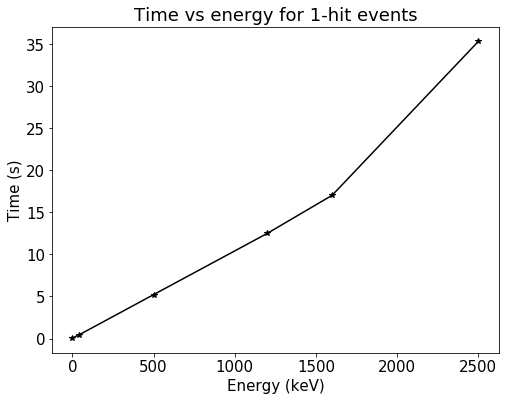

In [23]:
x = np.zeros(1)      * units.mm
y = np.zeros(1)      * units.mm
z = np.full (1, 400) * units.mm

Es = np.array([1, 40, 500, 1200, 1600, 2500], dtype=np.float)
ts = np.zeros_like(Es)
for i, e in enumerate(Es):
    E = np.full (1, e) * units.keV
    ts[i] = time_simulate_event(x, y, z, E, 25)

plt.plot(Es, ts, "k*-")
labels("Energy (keV)", "Time (s)", "Time vs energy for 1-hit events")

In [24]:
tsE = ts

### Number of hits dependence

#### 40 keV

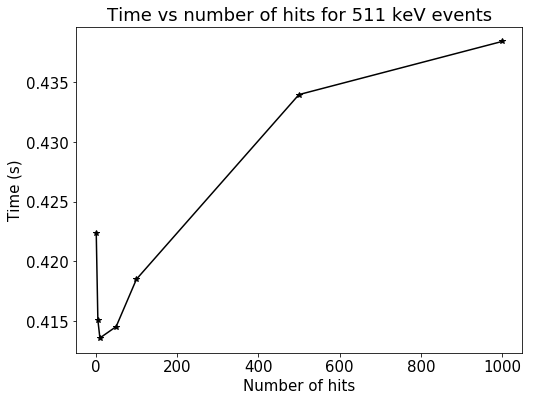

In [25]:
Ns = np.array([1, 5, 10, 50, 100, 500, 1000])
ts = np.zeros_like(Ns, dtype=np.float)
for i, n in enumerate(Ns):
    x = np.zeros(n)       * units.mm
    y = np.zeros(n)       * units.mm
    z = np.full (n, 400)  * units.mm
    E = np.full (n, 40/n) * units.keV
    ts[i] = time_simulate_event(x, y, z, E, 25)

plt.plot(Ns, ts, "k*-")
labels("Number of hits", "Time (s)", "Time vs number of hits for 40 keV events")

In [26]:
tsN40 = ts

#### 511 keV

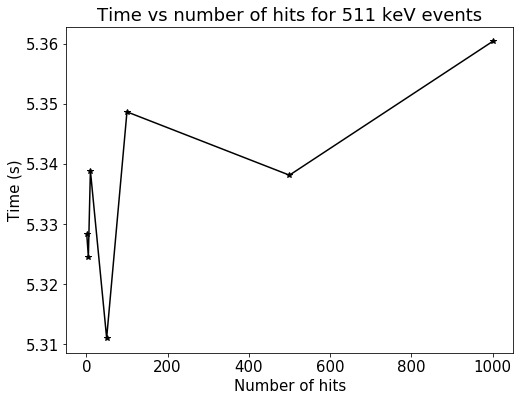

In [27]:
Ns = np.array([1, 5, 10, 50, 100, 500, 1000])
ts = np.zeros_like(Ns, dtype=np.float)
for i, n in enumerate(Ns):
    x = np.zeros(n)        * units.mm
    y = np.zeros(n)        * units.mm
    z = np.full (n, 400)   * units.mm
    E = np.full (n, 511/n) * units.keV
    ts[i] = time_simulate_event(x, y, z, E, 25)

plt.plot(Ns, ts, "k*-")
labels("Number of hits", "Time (s)", "Time vs number of hits for 511 keV events")

In [28]:
tsN511 = ts

#### 2.5 MeV

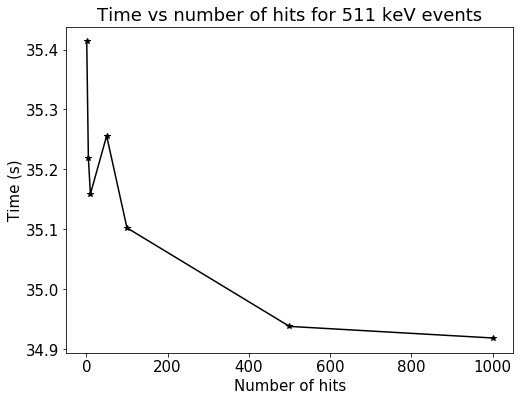

In [29]:
Ns = np.array([1, 5, 10, 50, 100, 500, 1000])
ts = np.zeros_like(Ns, dtype=np.float)
for i, n in enumerate(Ns):
    x = np.zeros(n)        * units.mm
    y = np.zeros(n)        * units.mm
    z = np.full (n, 400)   * units.mm
    E = np.full (n, 2.5/n) * units.MeV
    ts[i] = time_simulate_event(x, y, z, E, 25)

plt.plot(Ns, ts, "k*-")
labels("Number of hits", "Time (s)", "Time vs number of hits for 2.5 MeV events")

In [30]:
tsN2500 = ts